# Demo of Visually Grounded Story Generation


## Environment

In [6]:
# !pip install tqdm numpy pandas matplotlib openai datasets

In [7]:
import os
import math
from collections import defaultdict
import requests
from PIL import Image
from io import BytesIO
import base64

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
from datasets import load_dataset


In [29]:
IMG_PATH = 'images'

# OpenAI API Key
api_key = "YOUR_API_KEY" # Replace this with your real API key
openai.api_key = api_key

## Data loading

In [10]:
# Load the dataset
dataset = load_dataset("tonyhong/vwp")

# Convert the dataset to a pandas DataFrame
vwp = pd.DataFrame(dataset['val'])


In [11]:
vwp.shape

(849, 38)

In [12]:
val_data = vwp.query("split=='val'")
val_data.head()

,scene_full_id,link0,link1,link2,link3,link4,link5,link6,link7,link8,...,text7,text8,text9,img_id_list,story,sep_story,anonymised_story,split,imdb_id,story_id
0,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,None,None,None,...,None,None,None,"['tt0047396_0667_0', 'tt0047396_0668_0', 'tt00...",James and Thelma were spying on their neighbor...,James and Thelma were spying on their neighbor...,[male0] and [female0] were spying on their nei...,val,tt0047396,0
1,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,...,Raymond stands at his front door.,None,None,"['tt0047396_0667_0', 'tt0047396_0668_0', 'tt00...",Graces runs from a door as Raymond approaches....,Graces runs from a door as Raymond approaches....,[female0] runs from a door as [male0] approach...,val,tt0047396,1
2,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,None,None,None,...,None,None,None,"['tt0047396_0668_0', 'tt0047396_0669_0', 'tt00...",James is calling the cops. He and Thelma are t...,James is calling the cops. He and Thelma are t...,[male0] is calling the cops . he and [female0]...,val,tt0047396,2
3,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,None,None,None,...,None,None,None,"['tt0047396_0667_0', 'tt0047396_0668_0', 'tt00...","From the opposite apartment, Grace flees the a...","From the opposite apartment, Grace flees the a...","from the opposite apartment , [female0] flees ...",val,tt0047396,3
4,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,None,None,None,...,None,None,None,"['tt0047396_0667_0', 'tt0047396_0669_0', 'tt00...",Raymond approached the door to the apartment. ...,Raymond approached the door to the apartment. ...,[male0] approached the door to the apartment ....,val,tt0047396,4


In [13]:
small_val_data = val_data.head().copy()
small_val_data['output'] = ''
small_val_data.shape

(5, 39)

In [14]:
small_val_data.keys()

Index(['scene_full_id', 'link0', 'link1', 'link2', 'link3', 'link4', 'link5',
       'link6', 'link7', 'link8', 'link9', 'char0', 'char1', 'char2', 'char3',
       'char4', 'char0_url', 'char1_url', 'char2_url', 'char3_url',
       'char4_url', 'text0', 'text1', 'text2', 'text3', 'text4', 'text5',
       'text6', 'text7', 'text8', 'text9', 'img_id_list', 'story', 'sep_story',
       'anonymised_story', 'split', 'imdb_id', 'story_id', 'output'],
      dtype='object')

## Functions

In [34]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Get image descriptions
def generate_image_description(image_path):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    # Getting the base64 string
    if image_path[:5] != 'https':
        base64_image = encode_image(image_path)
        url = f"data:image/jpeg;base64,{base64_image}"
    else:
        url = image_path
    payload = {
        "model": "gpt-4o",
        "max_tokens": 200,
        "messages" : [
          {
            "role": "user",
            "content": [
              {
                "type": "text",
                "text": "What’s in this image?"
              },
              {
                "type": "image_url",
                "image_url": {
                  "url": url,
                }
              }
            ]
          }
        ]
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    print(response)
    return response.json()['choices'][0]['message']['content']

# Get descriptions from all images
def image_captioning(image_paths):
    descriptions = []
    for image_idx, image_path in tqdm(enumerate(image_paths)):
        description_response = generate_image_description(image_path)
        #print(f"Description of Image {image_idx+1}:", description_response, '\n')
        descriptions.append(description_response)
    return descriptions

# Function to generate a story based on descriptions of multiple images
def generate_story(descriptions):
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
          {
            "role": "user",
            "content": "Write a coherent story based on the following image descriptions: " + " ".join(descriptions) + " ####  Return just the story and nothing else",
          }
        ],
        temperature=0,
        max_tokens=300,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    story = response.choices[0].message.content
    return story

# Get a story directly
def visual_storytelling(image_paths):
    url_list = []
    for image_idx, image_path in tqdm(enumerate(image_paths)):
        # Getting the base64 string
        if image_path[:5] != 'https':
            base64_image = encode_image(image_path)
            url = f"data:image/jpeg;base64,{base64_image}"
        else:
            url = image_path
        url_list.append(url)

    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
    }
    content = [
              {
                "type": "text",
                "text": "These are frames from a video. Write a coherent short story using no more than 100 words based on these frames. Return just the story and nothing else. "
              }
            ]
    for url in url_list:
        content.append({
                "type": "image_url",
                "image_url": {
                  "url": url,
                }
              })
    payload = {
        "model": "gpt-4-vision-preview",
        "max_tokens": 300,
        "messages" : [
          {
            "role": "user",
            "content": content,
          }
        ]
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()['choices'][0]['message']['content']

In [27]:
data = small_val_data
data.keys()

Index(['scene_full_id', 'link0', 'link1', 'link2', 'link3', 'link4', 'link5',
       'link6', 'link7', 'link8', 'link9', 'char0', 'char1', 'char2', 'char3',
       'char4', 'char0_url', 'char1_url', 'char2_url', 'char3_url',
       'char4_url', 'text0', 'text1', 'text2', 'text3', 'text4', 'text5',
       'text6', 'text7', 'text8', 'text9', 'img_id_list', 'story', 'sep_story',
       'anonymised_story', 'split', 'imdb_id', 'story_id', 'output'],
      dtype='object')

## Examples

### Example 0: Using Functions

In [42]:
image_paths = ['https://datasets.d2.mpi-inf.mpg.de/xhong/VST/alpha4a/tt0047396_0010_0/shot_0667_img_0.jpg',
 'https://datasets.d2.mpi-inf.mpg.de/xhong/VST/alpha4a/tt0047396_0010_0/shot_0668_img_0.jpg',
 'https://datasets.d2.mpi-inf.mpg.de/xhong/VST/alpha4a/tt0047396_0010_0/shot_0671_img_1.jpg',
 'https://datasets.d2.mpi-inf.mpg.de/xhong/VST/alpha4a/tt0047396_0010_0/shot_0672_img_0.jpg',
 'https://datasets.d2.mpi-inf.mpg.de/xhong/VST/alpha4a/tt0047396_0010_0/shot_0693_img_0.jpg']

In [38]:
descriptions = image_captioning(image_paths)
# print('Descriptions: ', descriptions)

1it [00:04,  4.76s/it]

<Response [200]>


2it [00:07,  3.79s/it]

<Response [200]>


3it [00:12,  4.32s/it]

<Response [200]>


4it [00:15,  3.81s/it]

<Response [200]>


5it [00:19,  3.88s/it]

<Response [200]>


In [39]:
# Write a story with image descriptions
generated_story = generate_story(descriptions)
print('Story: ', generated_story)

Story:  The night was quiet, with only the soft glow of the streetlights illuminating the brick building. Through the windows, three separate scenes unfolded. On the left, a person in a blue coat and hat stood at the entrance to a room under a fire escape. In the middle, someone in light-colored clothing went about their household activities. And on the right, an illuminated living room showcased a table lamp and various furnishings.

Inside, two individuals were engaged in a tense moment. The man on the right held a phone to his ear, listening intently, while the woman on the left looked concerned, her finger pressed to her nose in a contemplative gesture. The scene was dramatic, as if taken from a film or television show, capturing a still moment in the dimly lit environment of the building.


### Example 1: 2-stage generation using online images 

Index:  0
Images: 


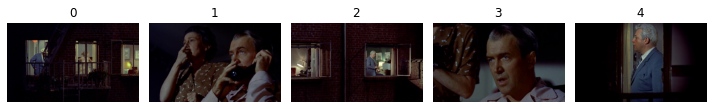

1it [00:03,  3.67s/it]

<Response [200]>


2it [00:07,  3.88s/it]

<Response [200]>


3it [00:13,  4.83s/it]

<Response [200]>


4it [00:16,  4.14s/it]

<Response [200]>


5it [00:19,  3.96s/it]

<Response [200]>
Image descriptions: 
0 This image depicts an exterior view of a building at night. There is a brick wall with several windows illuminated from the inside. One window on the left side shows a person in a blue garment and a hat, while a person in white is visible through the right middle window. A fire escape ladder runs diagonally across the image between the windows, and a small balcony with plants is visible beneath the windows. Inside, the rooms are lit and visible, with some furnishings and decorations seen through the windows. 

1 The image shows two people in a dark setting. An older woman is standing in the background with her hand near her face, appearing concerned or thoughtful. In the foreground, an older man is holding a telephone receiver to his ear. Both individuals appear to be focused and serious. The scene has a dramatic atmosphere, possibly from a film or a tense situation. 

2 The image shows the exterior of a brick building with two open windows. Thro


Generated story:  The old brick building stood tall and imposing in the darkness of the night. Through the illuminated windows, glimpses of life could be seen. In one window, a person in a blue garment and hat stood, while in another, a figure in white was visible. A fire escape ladder ran diagonally across the building, adding to the mysterious atmosphere.

Inside, two individuals were engaged in a serious conversation. An older woman stood in the background, her expression a mix of concern and thoughtfulness. In the foreground, an older man held a telephone receiver to his ear, his focus unwavering.

As the night wore on, the scene continued to unfold. Through the open windows of the building, the man in the blue suit and tie could be seen, standing in profile. The dim lighting added to the tension of the moment, as the events inside the building remained shrouded in mystery.

The night was filled with intrigue and suspense, as the lives of the individuals inside the building intert

In [41]:
cnt = 0
for idx in data.index:
    scene_full_id = data.loc[idx, 'scene_full_id']

    print('Index: ', idx)
    print('Images: ')
    image_paths = [data.loc[idx, 'link'+str(p)] for p in range(9) if not pd.isna(data.loc[idx, 'link'+str(p)])]
    human_story = data.loc[idx, 'story']

    length_y = math.ceil(len(image_paths) / 5)
    fig, axs = plt.subplots(length_y, 5, figsize=(10, 2*length_y))
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        if i < len(image_paths):
            response = requests.get(image_paths[i])
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

    # Call the captioner to generate image descriptions
    descriptions = image_captioning(image_paths)
    print('Image descriptions: ')
    [print(i, descriptions[i], '\n') for i in range(len(descriptions))]

    # Call the storyteller to generate story
    print('\nHuman story: ', human_story, '\n')

    generated_story = generate_story(descriptions)
    print('\nGenerated story: ', generated_story, '\n')
    print()

    cnt += 1
    if cnt > 0:
        break


### Example 2: 1-stage generation generation using local images

In [ ]:
cnt = 0
for idx in data.index:
    scene_full_id = data.loc[idx, 'scene_full_id']
    img_id_list = eval(data.loc[idx, 'img_id_list'])

    print('Index: ', idx)
    print('Images: ')
    image_paths = [os.path.join(IMG_PATH, img_id+'.jpg') for img_id in img_id_list]
    human_story = data.loc[idx, 'story']

    length_y = math.ceil(len(image_paths) / 5)
    fig, axs = plt.subplots(length_y, 5, figsize=(10, 2*length_y))
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

    # Call the storyteller to generate story
    print('Human story: ', human_story, '\n')

    generated_story = visual_storytelling(image_paths)
    print('Generated story: ', generated_story, '\n')
    print()

    cnt += 1
    if cnt > 0:
        break


### Example 3: 2-stage generation using local images

Index:  703
Images: 


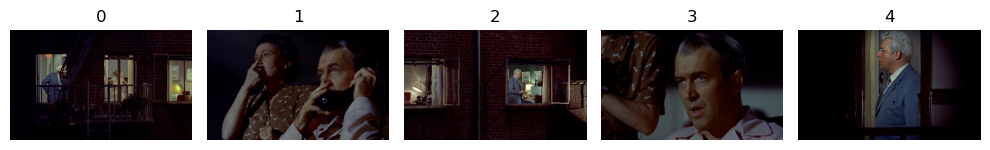

5it [00:39,  7.87s/it]


Image descriptions: 
0 The image depicts a nighttime scene of a brick building with multiple windows. There are various objects and details that can be seen:

1. Fire escape: A metal fire escape staircase is visible on the left side of the frame, suggesting this is a multi-story urban building.

2. Window view: Inside one of the brightly lit windows, it appears that there is a person standing, although the details are not clear.

3. Exterior details: On the balcony railing, there are flower pots, indicating someone has decorated this outdoor space.

4. Interior glimpse: Through the windows, you can see the interior lighting and some wall decorations, which give the impression of a cozy, inhabited space.

It's important to note that my responses are based on the visual content of the image, without any knowledge of its context that isn't visually represented.
1 This image depicts a scene with two individuals, one male and one female, sitting side by side. The man appears to be listening

In [ ]:
cnt = 0
for idx in data.index:
    scene_full_id = data.loc[idx, 'scene_full_id']
    img_id_list = eval(data.loc[idx, 'img_id_list'])

    print('Index: ', idx)
    print('Images: ')
    image_paths = [os.path.join(IMG_PATH, img_id+'.jpg') for img_id in img_id_list]
    human_story = data.loc[idx, 'story']

    length_y = math.ceil(len(image_paths) / 5)
    fig, axs = plt.subplots(length_y, 5, figsize=(10, 2*length_y))
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

    # Call the captioner to generate image descriptions
    descriptions = image_captioning(image_paths)
    print('Image descriptions: ')
    [print(i, descriptions[i]) for i in range(len(descriptions))]

    # Call the storyteller to generate story
    print('Human story: ', human_story, '\n')

    generated_story = generate_story(descriptions)
    print('Generated story: ', generated_story, '\n')
    print()

    cnt += 1
    if cnt > 0:
        break
